In [1]:
# Utility
from tqdm.notebook import tqdm
from typing import Union
import os

# Math and data manipulation
import numpy as np
import pandas as pd 
import random

# Datetime object manipulation
from datetime import datetime as dt

# Data Visualization
import matplotlib.pyplot as plt

# Data preprocessing

# Machine learning model
import tensorflow as tf

# Model Evaluation
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

# Parameter
PATH = 'Data/'
SEED = 2439
N_EPOCH = 100
TRAIN_SIZE = 0.7
DARK_THEME = 1
PLOT_SIZE = (17,7)

#Set Seed
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Set Plot Configuration
if DARK_THEME:
    import mplcyberpunk
    plt.style.use('cyberpunk')
else:
    plt.style.use('seaborn-v0_8')

plt.rcParams['figure.figsize'] = PLOT_SIZE 
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['axes.facecolor'] = 'white'


In [2]:
data = pd.read_excel(os.path.join(PATH, 'Data Inflasi.xlsx'), header=4)

data = data.iloc[-2::-1, :2] \
        .set_index('Periode')

In [3]:
train = data[:int(len(data)*TRAIN_SIZE)]
test = data[int(len(data)*TRAIN_SIZE):]

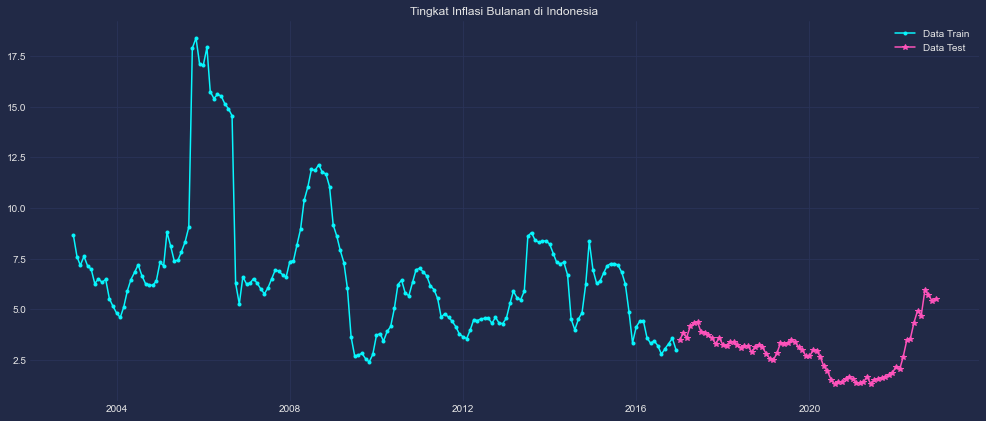

In [4]:
plt.title('Tingkat Inflasi Bulanan di Indonesia')
plt.plot(train, label='Data Train',marker='.')
plt.plot(test, label='Data Test', marker='*')
plt.legend()
plt.show()

In [5]:
def partition(sequence_length, data):
    """Function to

    Args:
        sequence_length (_type_): _description_
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    x, y = [], []
    data = np.array(data)
    for i in range(sequence_length, len(data) - sequence_length):
        x.append(data[i-sequence_length:i])
        y.append(data[i:i+1])
    
    x = np.array(x)
    y = np.array(y)
    return x, y

In [6]:
architectures = []
base = (5,5,5)
for i in range(-1,2):
    for j in range(-1,2):
        architectures.append([base[0]+i]*(len(base)+j))

In [7]:
def create_model(architecture: Union[tuple,list], seed=42):
    """Creating tensorflow model easier

    Args:
        architecture (tuple | list): Architecture of ANN model
        seed (int, optional): Random number seed. Defaults to 42.

    Returns:
        model: Tensorflow model
    """
    
    model = tf.keras.models.Sequential(
        tf.keras.layers.Flatten()
    )

    initializer = tf.keras.initializers.he_uniform(seed)

    for neuron in architecture[1:]:
        model.add(
            tf.keras.layers.Dense(
                units = neuron, 
                activation = 'relu', 
                kernel_initializer = initializer, 
                bias_initializer = initializer
                )
            )

    model.add(tf.keras.layers.Dense(1))
    # model.add(tf.keras.layers.Reshape([1, -1]),)

    optimizer = tf.keras.optimizers.Adam()

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=optimizer,
        )
    
    return model

In [8]:
def forecast(model, last_data, n):
    y = np.array([])
    len_input = len(last_data[0])

    for i in range(n):
        pred = model.predict(last_data, verbose=0)
        last_data = np.append(last_data[:,1:], pred).reshape(-1, len_input)
        y = np.append(y, pred)
        
    return y

In [9]:
histories = []
models = []
names = []
preds = []
mse = []
for architecture in architectures:
    x_train, y_train = partition(architecture[0], train)

    model = create_model(architecture, seed=SEED)

    history = model.fit(
                x=x_train,
                y=y_train,
                epochs=N_EPOCH,
                verbose=0, 
            )
    
    name = "-".join(map(str, architecture))
    # model.save(f'Model/{name}.h5')

    y_pred = forecast(model, x_train[-1].reshape(-1, architecture[0]), len(test)+12)
    error = MSE(test, y_pred[:-12])
    
    histories.append(history)
    models.append(model)
    names.append(name)
    preds.append(y_pred)
    mse.append(error)


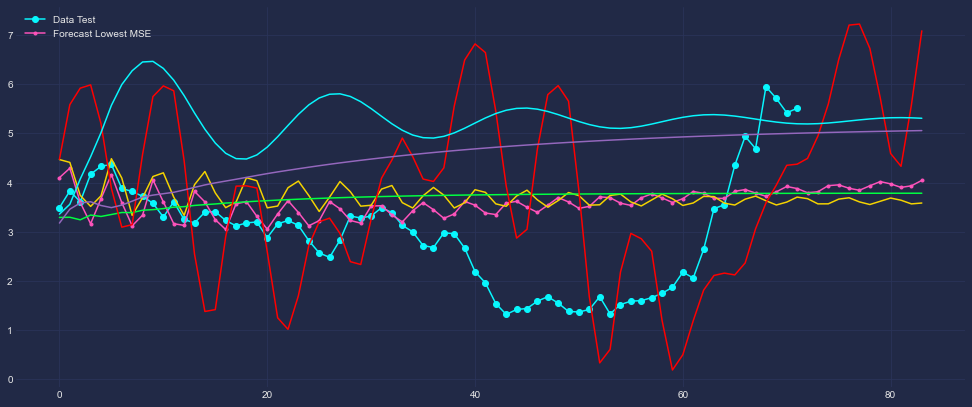

In [10]:
plt.plot(test.values, marker='o', label='Data Test')
plt.plot(preds[mse.index(min(mse))], marker='.', label='Forecast Lowest MSE')
plt.plot(preds[mse.index(sorted(mse)[1])])
plt.plot(preds[mse.index(sorted(mse)[2])])
plt.plot(preds[mse.index(sorted(mse)[3])])
plt.plot(preds[mse.index(sorted(mse)[4])])
plt.plot(preds[mse.index(sorted(mse)[5])])
# plt.plot(preds[mse.index(sorted(mse)[-1])])
plt.legend()
plt.show()

In [11]:
mse

[7.803841811579904,
 1.8760079361686717,
 1.5023477097878133e+25,
 3.8255018406091494,
 9.332909198973978,
 6.761023855443574,
 1.5509725254256388,
 3.997781624481064,
 1.82136690441919]

In [68]:
output = pd.DataFrame(dict(zip(names, preds)))

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (8).

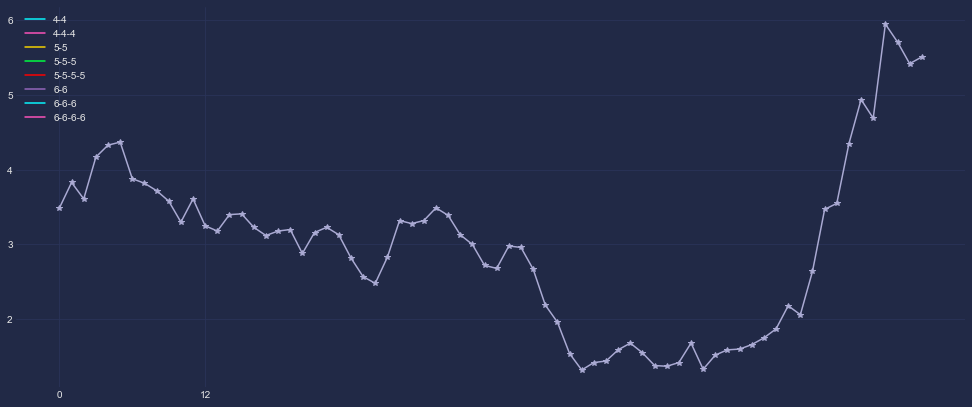

In [71]:
ax = output.drop('4-4-4-4',axis=1)[:-12].plot()
plt.plot(test.values, label='Data Test', marker='*', color='#aaaad3')
ax.set_xticks(list(range(0, len(output)+1,12)), list(range(2017,2025)))
plt.legend()
plt.show()

In [57]:
idx = pd.date_range(test.index[0],freq='MS', periods=len(test)+12)

In [63]:
output = output.set_index(idx)
output.index = output.index.rename('Periode')

In [64]:
output.to_csv('Output/Forecast.csv', float_format='%.2f')

In [65]:
histories = []
models = []
forecast = []
for architecture in architectures:
    x_train, y_train = partition(architecture[0], data)

    model = create_model(architecture, seed=SEED)

    history = model.fit(
                x=x_train,
                y=y_train,
                epochs=N_EPOCH,
                verbose=0, 
            )
    
    # model.save(f'Model/{name}.h5')

    y_pred = forecast(model, x_train[-1].reshape(-1, architecture[0]), 12)
    
    histories.append(history)
    models.append(model)
    names.append(name)
    forecast.append(y_pred)


In [66]:
preds

[array([4.23998308, 4.35295725, 4.45856047, 4.22711897, 4.2217021 ,
        4.20978403, 4.10822773, 4.06943512, 4.02786303, 3.96271801,
        3.9152112 , 3.86690426]),
 array([4.14089012, 4.20151567, 4.39443111, 4.27045488, 4.19846535,
        4.22375727, 4.2009325 , 4.16189814, 4.14653587, 4.13086033,
        4.10867023, 4.09022808]),
 array([4.42608261, 4.47619009, 4.87466669, 4.91399145, 4.9502058 ,
        5.09922695, 5.20831299, 5.28288794, 5.37516642, 5.4672246 ,
        5.54685545, 5.62430716]),
 array([4.2825346 , 4.3422718 , 4.40676737, 4.42645597, 4.62874699,
        4.78161526, 4.94679594, 5.08571291, 5.18402433, 5.28636646,
        5.38092709, 5.48255157]),
 array([4.65646982, 4.15057755, 4.21961069, 4.14631557, 3.69581008,
        3.80271745, 3.86556101, 3.63895655, 3.77014494, 3.82807088,
        3.64465189, 3.70859051]),
 array([4.88295746, 4.63654709, 4.79136133, 4.99881887, 4.76243591,
        4.77501869, 4.93100405, 4.81034613, 4.7978301 , 4.91670418,
        4.8628